## Отток клиентов из банка

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Постройте модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте F1-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте ROC-AUC, сравнивайте её значение с F1-мерой.

Источник данных: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

<b>Признаки</b>

+ RowNumber — индекс строки в данных
+ CustomerId — уникальный идентификатор клиента
+ Surname — фамилия
+ CreditScore — кредитный рейтинг
+ Geography — страна проживания
+ Gender — пол
+ Age — возраст
+ Tenure — количество недвижимости у клиента
+ Balance — баланс на счёте
+ NumOfProducts — количество продуктов банка, используемых клиентом
+ HasCrCard — наличие кредитной карты
+ IsActiveMember — активность клиента
+ EstimatedSalary — предполагаемая зарплата

<b>Целевой признак</b>

Exited — факт ухода клиента

<b>План работы над проектом</b>

1. Изучить данные. Разбить данные на тренировочную, валидационную и тестовую выборку.
2. Исследовать задачу. Проверить модели на данных без изменений.
3. Скоректировать балланс класса. Изменить вес класса, урезать 0 или добавить 1.
4. Получить улучшенную модель. Провести поиск гиперпараметров.
5. Провести финальный тест.
6. Написать вывод и оформить проект.

## 1.Подготовка данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

In [1]:
# функция для вывода состава столбцов
def describe_cols(df_data):
    df = df_data
    values = pd.DataFrame()
    
    for col in df.columns:
        values[col] = [df[col].unique(), df[col].dtypes, df[col].nunique()]
        
    return values.T.sort_values(by=1, ascending=True).rename(
        {0: 'Значения', 1: 'тип данных', 2: 'Кол-во уникальных значений'}, axis=1)


# функция для вывода пустых значений и их доли в столбцах датафрейма
def nan_values(df_data):
    df = df_data
    count_missing = df.isna().sum()
    percent_missing = round(df.isna().sum() * 100 / len(df), 1)
    
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'num_missing': count_missing,
                                     'percent_missing': percent_missing})
    
    return missing_value_df


# функция для вывода информации о файле
def df_info (df_data):
    print('Количество строк файла:', len(df_data))
    print()
    print('Информация о содержимом файла:')
    display(describe_cols(df_data))
    print()
    print('Информация о пропусках данных:')
    display(nan_values(df_data))
    print()
    print('Первые пять строк таблицы:')
    display(df_data.head())

# просмотр данных столбца: уникальные значения, тип данных, кол-во пропусков
def preprocessing(df, column):
    #print(column, '-', dict_name[column])
    print('Тип данных', df[column].dtypes)
    print('Количество пропусков',df[column].isna().sum())
    if df[column].dtypes != 'object':
        print('Минимальное значение:',df[column].min(), 'Максимальное значение:', df[column].max() )
    print('Уникальные значения:', '\n', df[column].value_counts())

In [4]:
df_info(df)

Количество строк файла: 10000

Информация о содержимом файла:


,Значения,тип данных,Кол-во уникальных значений
RowNumber,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",int64,10000
CustomerId,"[15634602, 15647311, 15619304, 15701354, 15737...",int64,10000
CreditScore,"[619, 608, 502, 699, 850, 645, 822, 376, 501, ...",int64,460
Age,"[42, 41, 39, 43, 44, 50, 29, 27, 31, 24, 34, 2...",int64,70
NumOfProducts,"[1, 3, 2, 4]",int64,4
HasCrCard,"[1, 0]",int64,2
IsActiveMember,"[1, 0]",int64,2
Exited,"[1, 0]",int64,2
Tenure,"[2.0, 1.0, 8.0, 7.0, 4.0, 6.0, 3.0, 10.0, 5.0,...",float64,11
Balance,"[0.0, 83807.86, 159660.8, 125510.82, 113755.78...",float64,6382



Информация о пропусках данных:


,column_name,num_missing,percent_missing
RowNumber,RowNumber,0,0.0
CustomerId,CustomerId,0,0.0
Surname,Surname,0,0.0
CreditScore,CreditScore,0,0.0
Geography,Geography,0,0.0
Gender,Gender,0,0.0
Age,Age,0,0.0
Tenure,Tenure,909,9.1
Balance,Balance,0,0.0
NumOfProducts,NumOfProducts,0,0.0



Первые пять строк таблицы:


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,9091.0,4.997690e+00,2.894723,0.00,2.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


Заменим все NaN из столбца Tenure на 0, если объектов недвижимости не указано то их нет.

In [6]:
df['Tenure'] = df['Tenure'].fillna(0)

In [7]:
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [8]:
df.isna().mean()

RowNumber          0.0
CustomerId         0.0
Surname            0.0
CreditScore        0.0
Geography          0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

In [9]:
df['Tenure'].value_counts()

0.0     1291
1.0      952
2.0      950
8.0      933
3.0      928
5.0      927
7.0      925
4.0      885
9.0      882
6.0      881
10.0     446
Name: Tenure, dtype: int64

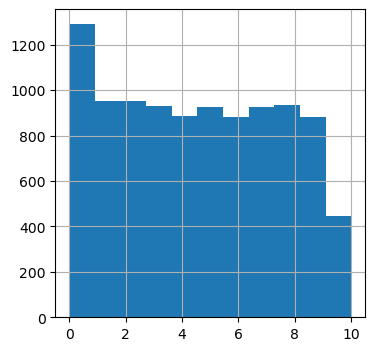

In [10]:
df['Tenure'].hist(bins=11,figsize=(4,4));

Удалим столбцы RowNumber,  и Surname, так как эти признаки ненужны при исследовании модели.
RowNumber повторяет индекс датафрейма. CustomerId случайный или последовательный номер, который никак не зависит от действий пользователя. Surname - признак, который отличается от человека к человеку и является именем в обществе, то не является гарантом того, что клиент останется или уйдет.

In [11]:
df = df.drop(['RowNumber','CustomerId','Surname'], axis=1).copy()
df.shape

(10000, 11)

In [12]:
df_new = pd.get_dummies(df, drop_first=True)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  float64
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


In [13]:
df_new

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7.0,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,1,0,1


<b>Вывод по шагу 1:</b>

Данные готовы к исследованию.
Были удалены не влияющие на конечный фактор данные. 

## 2.Исследование задачи

Будем использовать следующие модели:

+ Логистическая регрессия
+ Случайный лес
+ Дерево принятия решений
+ GaussianNB

Разобъем данные по принципу 60/20/20.

In [14]:
X = df_new.drop('Exited',axis=1)
y = df_new['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test , test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(6000, 11) (2000, 11) (2000, 11)
(6000,) (2000,) (2000,)


Посмотрим на дисбалланс классов:

In [15]:
y.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Соотношение классов 1:4. Изучим модели без исправления балланса.

### 2.1 Алгоритм Дерева принятия решений

Проведем исследование при разном значении max_depth:

In [16]:
%%time

best_depth = 0
best_f1 = 0

for depth in range(1, 50):
    model = DecisionTreeClassifier(random_state=42, max_depth=depth)
    model.fit(X_train, y_train)
    pred_val = model.predict(X_val)
    f1 = f1_score(y_val, pred_val)
    print('Max depth', depth,'F1-score', f1)
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth

print('Лучшая глубина дерева', best_depth,'Лучший F1_score', best_f1) 

Max depth 1 F1-score 0.0
Max depth 2 F1-score 0.47491638795986624
Max depth 3 F1-score 0.5008183306055646
Max depth 4 F1-score 0.47186932849364793
Max depth 5 F1-score 0.5080906148867315
Max depth 6 F1-score 0.527687296416938
Max depth 7 F1-score 0.5183946488294314
Max depth 8 F1-score 0.5149136577708006
Max depth 9 F1-score 0.5205479452054794
Max depth 10 F1-score 0.504424778761062
Max depth 11 F1-score 0.49855072463768113
Max depth 12 F1-score 0.48342541436464087
Max depth 13 F1-score 0.48807854137447404
Max depth 14 F1-score 0.48108108108108105
Max depth 15 F1-score 0.4723346828609986
Max depth 16 F1-score 0.4627659574468085
Max depth 17 F1-score 0.44297082228116713
Max depth 18 F1-score 0.4645669291338583
Max depth 19 F1-score 0.4603381014304292
Max depth 20 F1-score 0.47927461139896377
Max depth 21 F1-score 0.47382198952879584
Max depth 22 F1-score 0.46726572528883176
Max depth 23 F1-score 0.464935064935065
Max depth 24 F1-score 0.463130659767141
Max depth 25 F1-score 0.4641025641

### 2.2 Алгоритм Случайного леса

Проведем исследование при разном количестве деревьев:

In [17]:
%%time

best_estim = 0
best_f1 = 0

for estimator in range(50, 300, 10):
    model =  RandomForestClassifier(random_state=42, n_estimators=estimator)
    model.fit(X_train, y_train)
    pred_val = model.predict(X_val)
    f1 = f1_score(y_val, pred_val)
    print('N estimators', estimator,'F1', f1)
    if f1 > best_f1:
        best_f1 = f1
        best_estim = estimator

print('Лучшее количество деревьев', best_estim,'Лучший F1_score', best_f1)   

N estimators 50 F1 0.5544554455445544
N estimators 60 F1 0.5557404326123128
N estimators 70 F1 0.559463986599665
N estimators 80 F1 0.560530679933665
N estimators 90 F1 0.5681063122923588
N estimators 100 F1 0.5638474295190713
N estimators 110 F1 0.5638474295190713
N estimators 120 F1 0.5592105263157895
N estimators 130 F1 0.5562913907284768
N estimators 140 F1 0.5596026490066225
N estimators 150 F1 0.5586776859504132
N estimators 160 F1 0.5502471169686985
N estimators 170 F1 0.5529801324503312
N estimators 180 F1 0.5524126455906821
N estimators 190 F1 0.5572139303482586
N estimators 200 F1 0.5496688741721855
N estimators 210 F1 0.5490848585690516
N estimators 220 F1 0.5487603305785124
N estimators 230 F1 0.5472636815920399
N estimators 240 F1 0.5457570715474209
N estimators 250 F1 0.5538971807628523
N estimators 260 F1 0.5490848585690516
N estimators 270 F1 0.5514950166112956
N estimators 280 F1 0.5529801324503312
N estimators 290 F1 0.5520661157024793
Лучшее количество деревьев 90 Лу

Лучший результат был получен в районе 80-100 n_estimators. Сделаем исследование с шагом 1.

In [18]:
%%time

best_estim = 0
best_f1 = 0

for estimator in range(79, 101, 1):
    model =  RandomForestClassifier(random_state=42, n_estimators=estimator)
    model.fit(X_train, y_train)
    pred_val = model.predict(X_val)
    f1 = f1_score(y_val, pred_val)
    print('N estimators', estimator,'F1', f1)
    if f1 > best_f1:
        best_f1 = f1
        best_estim = estimator

print('Лучшее количество деревьев', best_estim,'Лучший F1_score', best_f1)

N estimators 79 F1 0.5634266886326195
N estimators 80 F1 0.560530679933665
N estimators 81 F1 0.5652892561983471
N estimators 82 F1 0.5662251655629138
N estimators 83 F1 0.5652892561983471
N estimators 84 F1 0.562396006655574
N estimators 85 F1 0.5638474295190713
N estimators 86 F1 0.5633333333333334
N estimators 87 F1 0.5638474295190713
N estimators 88 F1 0.5647840531561462
N estimators 89 F1 0.5662251655629138
N estimators 90 F1 0.5681063122923588
N estimators 91 F1 0.5643564356435644
N estimators 92 F1 0.5652892561983471
N estimators 93 F1 0.5643564356435644
N estimators 94 F1 0.5662251655629138
N estimators 95 F1 0.5652892561983471
N estimators 96 F1 0.5629139072847682
N estimators 97 F1 0.5652892561983471
N estimators 98 F1 0.5638474295190713
N estimators 99 F1 0.5652892561983471
N estimators 100 F1 0.5638474295190713
Лучшее количество деревьев 90 Лучший F1_score 0.5681063122923588
Wall time: 9.7 s


### 2.3 Алгоритм Логистической регрессии

In [19]:
%%time

model =  LogisticRegression(random_state=42, solver='liblinear')
model.fit(X_train, y_train)
pred_val = model.predict(X_val)
print('F1', f1_score(y_val, pred_val))

F1 0.044226044226044224
Wall time: 15.1 ms


Результаты довольно низкие. Возможно precision или recall низкий и близок к 0.

### 2.4 Алгоритм Гаусовско-Баейсовский

In [20]:
%%time

model =  GaussianNB()
model.fit(X_train, y_train)
pred_val = model.predict(X_val)
print('F1', f1_score(y_val, pred_val))

F1 0.11612903225806451
Wall time: 1.58 ms


Похожий результат, как и логистической регресии.

###  2.5 Проведем оценку accuracy, precision и recall, также покажем F-метрику.

In [21]:
%%time

model = DecisionTreeClassifier(random_state=42, max_depth=6)
model.fit(X_train, y_train)
pred_val = model.predict(X_val)
print('Решающее дерево')
print('Точность попадания по классам', accuracy_score(y_val, pred_val))
print('Precision', precision_score(y_val, pred_val))
print('Recall', recall_score(y_val, pred_val))
print('F1', f1_score(y_val, pred_val))
print()

model = RandomForestClassifier(random_state=42, n_estimators=90)
model.fit(X_train, y_train)
pred_val = model.predict(X_val)
print('Случайный лес')
print('Точность попадания по классам', accuracy_score(y_val, pred_val))
print('Precision', precision_score(y_val, pred_val))
print('Recall', recall_score(y_val, pred_val))
print('F1', f1_score(y_val, pred_val))
print()

model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(X_train, y_train)
pred_val = model.predict(X_val)
print('Логистическая регрессия')
print('Точность попадания по классам', accuracy_score(y_val, pred_val))
print('Precision', precision_score(y_val, pred_val))
print('Recall', recall_score(y_val, pred_val))
print('F1', f1_score(y_val, pred_val))
print()

model = GaussianNB()
model.fit(X_train, y_train)
pred_val = model.predict(X_val)
print('Гаусовская байсовая модель')
print('Точность попадания по классам', accuracy_score(y_val, pred_val))
print('Precision', precision_score(y_val, pred_val))
print('Recall', recall_score(y_val, pred_val))
print('F1', f1_score(y_val, pred_val))
print()

Решающее дерево
Точность попадания по классам 0.855
Precision 0.6923076923076923
Recall 0.4263157894736842
F1 0.527687296416938

Случайный лес
Точность попадания по классам 0.87
Precision 0.7702702702702703
Recall 0.45
F1 0.5681063122923588

Логистическая регрессия
Точность попадания по классам 0.8055
Precision 0.3333333333333333
Recall 0.02368421052631579
F1 0.044226044226044224

Гаусовская байсовая модель
Точность попадания по классам 0.7945
Precision 0.3176470588235294
Recall 0.07105263157894737
F1 0.11612903225806451

Wall time: 473 ms


### 2.5 Проведем построение ROC-кривой для кажддой модели. И выведем показатель AUC-ROC.

AUC-ROC DecisionTreeClassifier 0.8073984730344379
AUC-ROC RandomForestClassifier 0.832496751137102
AUC-ROC LogisticRegression 0.6360786224821312
AUC-ROC GaussianNB 0.7088352826510721


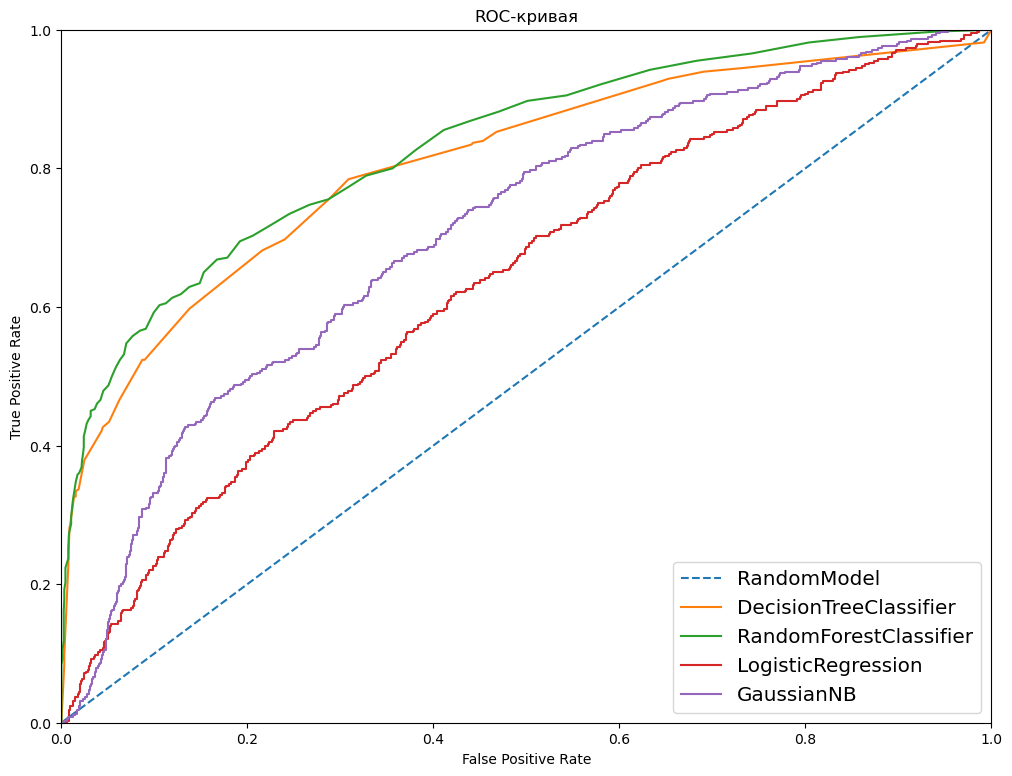

In [22]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


model = DecisionTreeClassifier(random_state=42, max_depth=6)
model.fit(X_train, y_train)
probabilities_valid = model.predict_proba(X_val)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, probabilities_one_valid)
auc_roc = roc_auc_score(y_val, probabilities_one_valid)
print('AUC-ROC DecisionTreeClassifier',auc_roc)
plt.plot(fpr, tpr, label='DecisionTreeClassifier')

model = RandomForestClassifier(random_state=42, n_estimators=90)
model.fit(X_train, y_train)
probabilities_valid = model.predict_proba(X_val)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, probabilities_one_valid)
auc_roc = roc_auc_score(y_val, probabilities_one_valid)
print('AUC-ROC RandomForestClassifier',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier')

model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(X_train, y_train)
probabilities_valid = model.predict_proba(X_val)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, probabilities_one_valid)
auc_roc = roc_auc_score(y_val, probabilities_one_valid)
print('AUC-ROC LogisticRegression',auc_roc)
plt.plot(fpr, tpr, label='LogisticRegression')

model = GaussianNB()
model.fit(X_train, y_train)
probabilities_valid = model.predict_proba(X_val)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, probabilities_one_valid)
auc_roc = roc_auc_score(y_val, probabilities_one_valid)
print('AUC-ROC GaussianNB',auc_roc)
plt.plot(fpr, tpr, label='GaussianNB')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

По полученным реззультатам можно заменить, что метрика f1 и ROC-AUC лучшая на случаном лесе.

### Вывод по шагу 2
В данных сущестует дисбаланс классов в отношении 1:4.

Возможно он влияет на качество изучаемых моделей.

Все модели имеют recall ниже, чем percision, из-за перекоса данных, что влияет на F-меру.

## 3. Борьба с дисбалансом

Для борьбы с дисбалансом выполним сравнение моделей:

+ С взвешенными классами
+ С уменьшенной выборкой
+ С увеличенной выборкой

### 3.1 Изучим возможности моделей по взвешиванию классов:

In [23]:
%%time

model = DecisionTreeClassifier(random_state=42, max_depth=6, class_weight='balanced')
model.fit(X_train, y_train)
pred_val = model.predict(X_val)
print('Решающее дерево')
print('Точность попадания по классам', accuracy_score(y_val, pred_val))
print('Precision', precision_score(y_val, pred_val))
print('Recall', recall_score(y_val, pred_val))
print('F1', f1_score(y_val, pred_val))
print()

model = RandomForestClassifier(random_state=42, n_estimators=90, class_weight='balanced')
model.fit(X_train, y_train)
pred_val = model.predict(X_val)
print('Случайный лес')
print('Точность попадания по классам', accuracy_score(y_val, pred_val))
print('Precision', precision_score(y_val, pred_val))
print('Recall', recall_score(y_val, pred_val))
print('F1', f1_score(y_val, pred_val))
print()

model = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')
model.fit(X_train, y_train)
pred_val = model.predict(X_val)
print('Логистическая регрессия')
print('Точность попадания по классам', accuracy_score(y_val, pred_val))
print('Precision', precision_score(y_val, pred_val))
print('Recall', recall_score(y_val, pred_val))
print('F1', f1_score(y_val, pred_val))
print()

'''
у выбранной модели нет возможности взвешивать классы
model = GaussianNB()
model.fit(X_train, y_train)
pred_val = model.predict(X_val)
print('Гаусовская байсовая модель')
print('Точность попадания по классам', accuracy_score(y_val, pred_val))
print('Precision', precision_score(y_val, pred_val))
print('Recall', recall_score(y_val, pred_val))
print('F1', f1_score(y_val, pred_val))
print()'''


Решающее дерево
Точность попадания по классам 0.7575
Precision 0.41732283464566927
Recall 0.6973684210526315
F1 0.522167487684729

Случайный лес
Точность попадания по классам 0.8675
Precision 0.7625570776255708
Recall 0.4394736842105263
F1 0.5575959933222037

Логистическая регрессия
Точность попадания по классам 0.6405
Precision 0.2935444579780755
Recall 0.6342105263157894
F1 0.40133222314737715

Wall time: 470 ms


"\nу выбранной модели нет возможности взвешивать классы\nmodel = GaussianNB()\nmodel.fit(X_train, y_train)\npred_val = model.predict(X_val)\nprint('Гаусовская байсовая модель')\nprint('Точность попадания по классам', accuracy_score(y_val, pred_val))\nprint('Precision', precision_score(y_val, pred_val))\nprint('Recall', recall_score(y_val, pred_val))\nprint('F1', f1_score(y_val, pred_val))\nprint()"

F-мера упала у решающего дерева и случайного леса, но выросла в разы у логистической регресии.

### 3.2 Исследуем способ уменьшения значений класса 0:

In [24]:
def downsample(features, target, fraction):
    X_zeros = features[target == 0]
    X_ones = features[target == 1]
    y_zeros = target[target == 0]
    y_ones = target[target == 1]
    
    X_downsampled = pd.concat(
        [X_zeros.sample(frac=fraction, random_state=42)] + [X_ones])
    y_downsampled = pd.concat(
        [y_zeros.sample(frac=fraction, random_state=42)] + [y_ones])
    
    X_downsampled, y_downsampled = shuffle(
        X_downsampled, y_downsampled, random_state=42)
    
    return X_downsampled, y_downsampled

X_downsampled, y_downsampled = downsample(X_train, y_train, 0.25)

print(y_downsampled.value_counts())
    

1    1227
0    1193
Name: Exited, dtype: int64


In [25]:
%%time

model = DecisionTreeClassifier(random_state=42, max_depth=6)
model.fit(X_downsampled, y_downsampled)
pred_val = model.predict(X_val)
print('Решающее дерево')
print('Точность попадания по классам', accuracy_score(y_val, pred_val))
print('Precision', precision_score(y_val, pred_val))
print('Recall', recall_score(y_val, pred_val))
print('F1', f1_score(y_val, pred_val))
print()

model = RandomForestClassifier(random_state=42, n_estimators=90)
model.fit(X_downsampled, y_downsampled)
pred_val = model.predict(X_val)
print('Случайный лес')
print('Точность попадания по классам', accuracy_score(y_val, pred_val))
print('Precision', precision_score(y_val, pred_val))
print('Recall', recall_score(y_val, pred_val))
print('F1', f1_score(y_val, pred_val))
print()

model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(X_downsampled, y_downsampled)
pred_val = model.predict(X_val)
print('Логистическая регрессия')
print('Точность попадания по классам', accuracy_score(y_val, pred_val))
print('Precision', precision_score(y_val, pred_val))
print('Recall', recall_score(y_val, pred_val))
print('F1', f1_score(y_val, pred_val))
print()

model = GaussianNB()
model.fit(X_downsampled, y_downsampled)
pred_val = model.predict(X_val)
print('Гаусовская байсовая модель')
print('Точность попадания по классам', accuracy_score(y_val, pred_val))
print('Precision', precision_score(y_val, pred_val))
print('Recall', recall_score(y_val, pred_val))
print('F1', f1_score(y_val, pred_val))
print()

Решающее дерево
Точность попадания по классам 0.7105
Precision 0.36993464052287583
Recall 0.7447368421052631
F1 0.4943231441048035

Случайный лес
Точность попадания по классам 0.7715
Precision 0.4367816091954023
Recall 0.7
F1 0.5379170879676441

Логистическая регрессия
Точность попадания по классам 0.6285
Precision 0.28672150411280845
Recall 0.6421052631578947
F1 0.39642567018683994

Гаусовская байсовая модель
Точность попадания по классам 0.6695
Precision 0.3129161118508655
Recall 0.618421052631579
F1 0.41556145004420864

Wall time: 223 ms


Показатели логистической регрессии и гаусовской модели выросли. Решающее дерево и случайный лес показали себя хуже.

### 3.3 Исследуем методы увеличения класса 1:

In [26]:
def upsample(features, target, repeat):
    X_zeros = features[target == 0]
    X_ones = features[target == 1]
    y_zeros = target[target == 0]
    y_ones = target[target == 1]

    features_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    target_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=42)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(X_train, y_train, 4)

print(target_upsampled.value_counts())

1    4908
0    4773
Name: Exited, dtype: int64


In [27]:
%%time

model = DecisionTreeClassifier(random_state=42, max_depth=6)
model.fit(features_upsampled, target_upsampled)
pred_val = model.predict(X_val)
print('Решающее дерево')
print('Точность попадания по классам', accuracy_score(y_val, pred_val))
print('Precision', precision_score(y_val, pred_val))
print('Recall', recall_score(y_val, pred_val))
print('F1', f1_score(y_val, pred_val))
print()

model = RandomForestClassifier(random_state=42, n_estimators=90)
model.fit(features_upsampled, target_upsampled)
pred_val = model.predict(X_val)
print('Случайный лес')
print('Точность попадания по классам', accuracy_score(y_val, pred_val))
print('Precision', precision_score(y_val, pred_val))
print('Recall', recall_score(y_val, pred_val))
print('F1', f1_score(y_val, pred_val))
print()

model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
pred_val = model.predict(X_val)
print('Логистическая регрессия')
print('Точность попадания по классам', accuracy_score(y_val, pred_val))
print('Precision', precision_score(y_val, pred_val))
print('Recall', recall_score(y_val, pred_val))
print('F1', f1_score(y_val, pred_val))
print()

model = GaussianNB()
model.fit(features_upsampled, target_upsampled)
pred_val = model.predict(X_val)
print('Гаусовская байсовая модель')
print('Точность попадания по классам', accuracy_score(y_val, pred_val))
print('Precision', precision_score(y_val, pred_val))
print('Recall', recall_score(y_val, pred_val))
print('F1', f1_score(y_val, pred_val))
print()

Решающее дерево
Точность попадания по классам 0.758
Precision 0.41798107255520506
Recall 0.6973684210526315
F1 0.5226824457593688

Случайный лес
Точность попадания по классам 0.8475
Precision 0.6190476190476191
Recall 0.5131578947368421
F1 0.5611510791366907

Логистическая регрессия
Точность попадания по классам 0.626
Precision 0.28454332552693207
Recall 0.6394736842105263
F1 0.3938411669367909

Гаусовская байсовая модель
Точность попадания по классам 0.6725
Precision 0.31241473396998637
Recall 0.6026315789473684
F1 0.41150044923629836

Wall time: 657 ms


F-мера стала лучше у логистической регресии и гаусовской модели по сравнению с дисбалансными данными.

<b>Лучшей моделью по F-мера стал случайны лес с тренировочными и дисбалансными данными.

Выведем ROC-кривую и AUC-ROC для посленнего измененного баланса.

AUC-ROC DecisionTreeClassifier 0.8085997400909681
AUC-ROC RandomForestClassifier 0.8284210526315791
AUC-ROC LogisticRegression 0.6822173489278753
AUC-ROC GaussianNB 0.7091731643924626


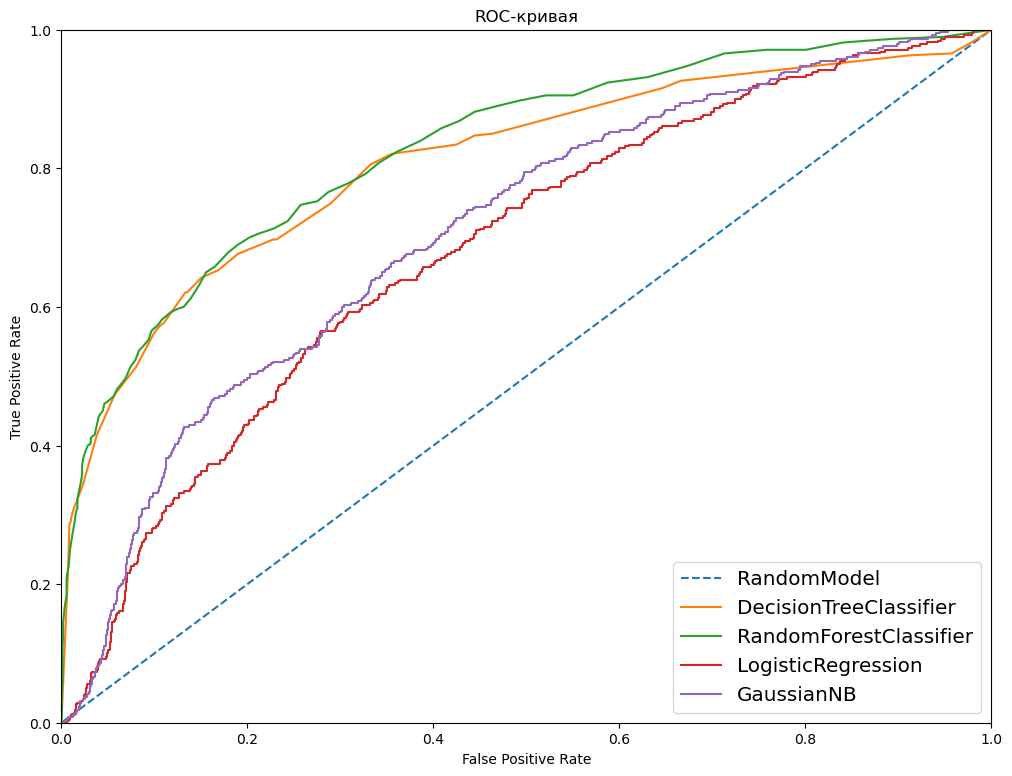

In [28]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


model = DecisionTreeClassifier(random_state=42, max_depth=6)
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(X_val)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, probabilities_one_valid)
auc_roc = roc_auc_score(y_val, probabilities_one_valid)
print('AUC-ROC DecisionTreeClassifier',auc_roc)
plt.plot(fpr, tpr, label='DecisionTreeClassifier')

model = RandomForestClassifier(random_state=42, n_estimators=90)
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(X_val)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, probabilities_one_valid)
auc_roc = roc_auc_score(y_val, probabilities_one_valid)
print('AUC-ROC RandomForestClassifier',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier')

model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(X_val)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, probabilities_one_valid)
auc_roc = roc_auc_score(y_val, probabilities_one_valid)
print('AUC-ROC LogisticRegression',auc_roc)
plt.plot(fpr, tpr, label='LogisticRegression')

model = GaussianNB()
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(X_val)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, probabilities_one_valid)
auc_roc = roc_auc_score(y_val, probabilities_one_valid)
print('AUC-ROC GaussianNB',auc_roc)
plt.plot(fpr, tpr, label='GaussianNB')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

<b>Вывод по шагу 3</b>

Дисбаланс повлиял на модели в лучшую сторону. Лучшим решением стало сохранить дисбаланс классов.

Выравние классов в выборке привело к резкому росту параметра recall и небольшому понижению percison. 

## 4. Тестирование модели

### 4.1 К тестовой выборке примем модель случайного дерева. Исследуем гиперпараметры и улучшим F-меру модели.

<b>Начнем с гиперпараметра n_estimators.

In [29]:
%%time

for estimator in range(10, 500, 10):
    model =  RandomForestClassifier(random_state=42, n_estimators=estimator)
    model.fit(X_train, y_train)
    pred_val = model.predict(X_val)
    print('N estimators', estimator,'F1', f1_score(y_val, pred_val))

N estimators 10 F1 0.5238879736408567
N estimators 20 F1 0.5397350993377483
N estimators 30 F1 0.5403624382207579
N estimators 40 F1 0.5544554455445544
N estimators 50 F1 0.5544554455445544
N estimators 60 F1 0.5557404326123128
N estimators 70 F1 0.559463986599665
N estimators 80 F1 0.560530679933665
N estimators 90 F1 0.5681063122923588
N estimators 100 F1 0.5638474295190713
N estimators 110 F1 0.5638474295190713
N estimators 120 F1 0.5592105263157895
N estimators 130 F1 0.5562913907284768
N estimators 140 F1 0.5596026490066225
N estimators 150 F1 0.5586776859504132
N estimators 160 F1 0.5502471169686985
N estimators 170 F1 0.5529801324503312
N estimators 180 F1 0.5524126455906821
N estimators 190 F1 0.5572139303482586
N estimators 200 F1 0.5496688741721855
N estimators 210 F1 0.5490848585690516
N estimators 220 F1 0.5487603305785124
N estimators 230 F1 0.5472636815920399
N estimators 240 F1 0.5457570715474209
N estimators 250 F1 0.5538971807628523
N estimators 260 F1 0.54908485856905

Лучший результат лежит в диапазоне 80-100

In [30]:
%%time

for estimator in range(80, 100):
    model =  RandomForestClassifier(random_state=42, n_estimators=estimator)
    model.fit(X_train, y_train)
    pred_val = model.predict(X_val)
    print('N estimators', estimator,'F1', f1_score(y_val, pred_val))

N estimators 80 F1 0.560530679933665
N estimators 81 F1 0.5652892561983471
N estimators 82 F1 0.5662251655629138
N estimators 83 F1 0.5652892561983471
N estimators 84 F1 0.562396006655574
N estimators 85 F1 0.5638474295190713
N estimators 86 F1 0.5633333333333334
N estimators 87 F1 0.5638474295190713
N estimators 88 F1 0.5647840531561462
N estimators 89 F1 0.5662251655629138
N estimators 90 F1 0.5681063122923588
N estimators 91 F1 0.5643564356435644
N estimators 92 F1 0.5652892561983471
N estimators 93 F1 0.5643564356435644
N estimators 94 F1 0.5662251655629138
N estimators 95 F1 0.5652892561983471
N estimators 96 F1 0.5629139072847682
N estimators 97 F1 0.5652892561983471
N estimators 98 F1 0.5638474295190713
N estimators 99 F1 0.5652892561983471
Wall time: 8.69 s


Лучший F1 при n_estimators = 90

<b> Изменеим гиперпараметр criterion

In [31]:
%%time

model =  RandomForestClassifier(random_state=42, n_estimators=90, criterion='entropy')
model.fit(X_train, y_train)
pred_val = model.predict(X_val)
print('F1', f1_score(y_val, pred_val))

F1 0.5538971807628523
Wall time: 525 ms


Изменений в лучшую сторону нет.

<b> Изменим гиперпараметр min_samples_split.

In [32]:
%%time

for samples_split in range(1, 11):
    model =  RandomForestClassifier(random_state=42, n_estimators=90, min_samples_split=samples_split/10)
    model.fit(X_train, y_train)
    pred_val = model.predict(X_val)
    print('Samples_split', samples_split/10,'F1', f1_score(y_val, pred_val))
    
for samples_split in range(2, 11):
    model =  RandomForestClassifier(random_state=42, n_estimators=estimator, min_samples_split=samples_split)
    model.fit(X_train, y_train)
    pred_val = model.predict(X_val)
    print('Samples_split', samples_split,'F1', f1_score(y_val, pred_val))

Samples_split 0.1 F1 0.3595041322314049
Samples_split 0.2 F1 0.20417633410672853
Samples_split 0.3 F1 0.11881188118811882
Samples_split 0.4 F1 0.0
Samples_split 0.5 F1 0.0
Samples_split 0.6 F1 0.0
Samples_split 0.7 F1 0.0
Samples_split 0.8 F1 0.0
Samples_split 0.9 F1 0.0
Samples_split 1.0 F1 0.0
Samples_split 2 F1 0.5652892561983471
Samples_split 3 F1 0.5560975609756098
Samples_split 4 F1 0.5529801324503312
Samples_split 5 F1 0.5625000000000001
Samples_split 6 F1 0.5667215815485996
Samples_split 7 F1 0.5602605863192183
Samples_split 8 F1 0.5496688741721855
Samples_split 9 F1 0.5488215488215488
Samples_split 10 F1 0.5633333333333334
Wall time: 5.75 s


Лучший F1 получени при min_samples_split=6

<b> Изменим гиперпараметр min_samples_leaf.

In [33]:
%%time

for samples_leaf in range(1, 6):
    model =  RandomForestClassifier(random_state=42, n_estimators=90, min_samples_split=6, 
                                    min_samples_leaf= samples_leaf/10)
    model.fit(X_train, y_train)
    pred_val = model.predict(X_val)
    print('Samples_leaf', samples_leaf/10,'F1', f1_score(y_val, pred_val))
    
for samples_leaf in range(1, 11):
    model =  RandomForestClassifier(random_state=42, n_estimators=estimator, min_samples_split=6,
                                   min_samples_leaf= samples_leaf)
    model.fit(X_train, y_train)
    pred_val = model.predict(X_val)
    print('Samples_leaf', samples_leaf,'F1', f1_score(y_val, pred_val))

Samples_leaf 0.1 F1 0.0
Samples_leaf 0.2 F1 0.0
Samples_leaf 0.3 F1 0.0
Samples_leaf 0.4 F1 0.0
Samples_leaf 0.5 F1 0.0
Samples_leaf 1 F1 0.5667215815485996
Samples_leaf 2 F1 0.5500000000000002
Samples_leaf 3 F1 0.5581395348837209
Samples_leaf 4 F1 0.5463743676222597
Samples_leaf 5 F1 0.5521885521885522
Samples_leaf 6 F1 0.5383304940374787
Samples_leaf 7 F1 0.5494880546075085
Samples_leaf 8 F1 0.5476190476190477
Samples_leaf 9 F1 0.5463917525773195
Samples_leaf 10 F1 0.5370051635111877
Wall time: 4.88 s


Лучший показатель min_samples_leaf = 1

### 4.2 Проверим на тестовой выборке четыре модели: 
+ на дисбалансных данных 
+ и сбалансированных: 
  + со взвешенными классами, 
  + усечением 0 класса 
  + расширением класса 1


In [34]:
model = RandomForestClassifier(random_state=42, n_estimators=90)
model.fit(X_train, y_train)
pred_test = model.predict(X_test)
print('Случайный лес - дисбаланс классов')
print('Точность попадания по классам', accuracy_score(y_test, pred_test))
print('Precision', precision_score(y_test, pred_test))
print('Recall', recall_score(y_test, pred_test))
print('F1', f1_score(y_test, pred_test))
print()

model = RandomForestClassifier(random_state=42, n_estimators=90, class_weight='balanced')
model.fit(X_train, y_train)
pred_test = model.predict(X_test)
print('Случайный лес - взвешенные классы')
print('Точность попадания по классам', accuracy_score(y_test, pred_test))
print('Precision', precision_score(y_test, pred_test))
print('Recall', recall_score(y_test, pred_test))
print('F1', f1_score(y_test, pred_test))
print()

model = RandomForestClassifier(random_state=42, n_estimators=90)
model.fit(X_downsampled, y_downsampled)
pred_test = model.predict(X_test)
print('Случайный лес - уменьшенное количество классов 0')
print('Точность попадания по классам', accuracy_score(y_test, pred_test))
print('Precision', precision_score(y_test, pred_test))
print('Recall', recall_score(y_test, pred_test))
print('F1', f1_score(y_test, pred_test))
print()

model = RandomForestClassifier(random_state=42, n_estimators=90)
model.fit(features_upsampled, target_upsampled)
pred_test = model.predict(X_test)
print('Случайный лес - увеличенное количество классов 1')
print('Точность попадания по классам', accuracy_score(y_test, pred_test))
print('Precision', precision_score(y_test, pred_test))
print('Recall', recall_score(y_test, pred_test))
print('F1', f1_score(y_test, pred_test))
print()

Случайный лес - дисбаланс классов
Точность попадания по классам 0.8605
Precision 0.7915057915057915
Recall 0.47674418604651164
F1 0.5950653120464442

Случайный лес - взвешенные классы
Точность попадания по классам 0.856
Precision 0.7983193277310925
Recall 0.4418604651162791
F1 0.5688622754491017

Случайный лес - уменьшенное количество классов 0
Точность попадания по классам 0.787
Precision 0.5030395136778115
Recall 0.7697674418604651
F1 0.6084558823529411

Случайный лес - увеличенное количество классов 1
Точность попадания по классам 0.85
Precision 0.6934523809523809
Recall 0.541860465116279
F1 0.6083550913838119



### 4.3 Построим ROC кривую

AUC-ROC RandomForestClassifier - disbalanced 0.8590631017627018
AUC-ROC RandomForestClassifier - balanced by class weight 0.8598170641386461
AUC-ROC RandomForestClassifier - balanced by reduce 0 class 0.8588253592060435
AUC-ROC RandomForestClassifier - balanced by grow 1 class 0.857724040882832


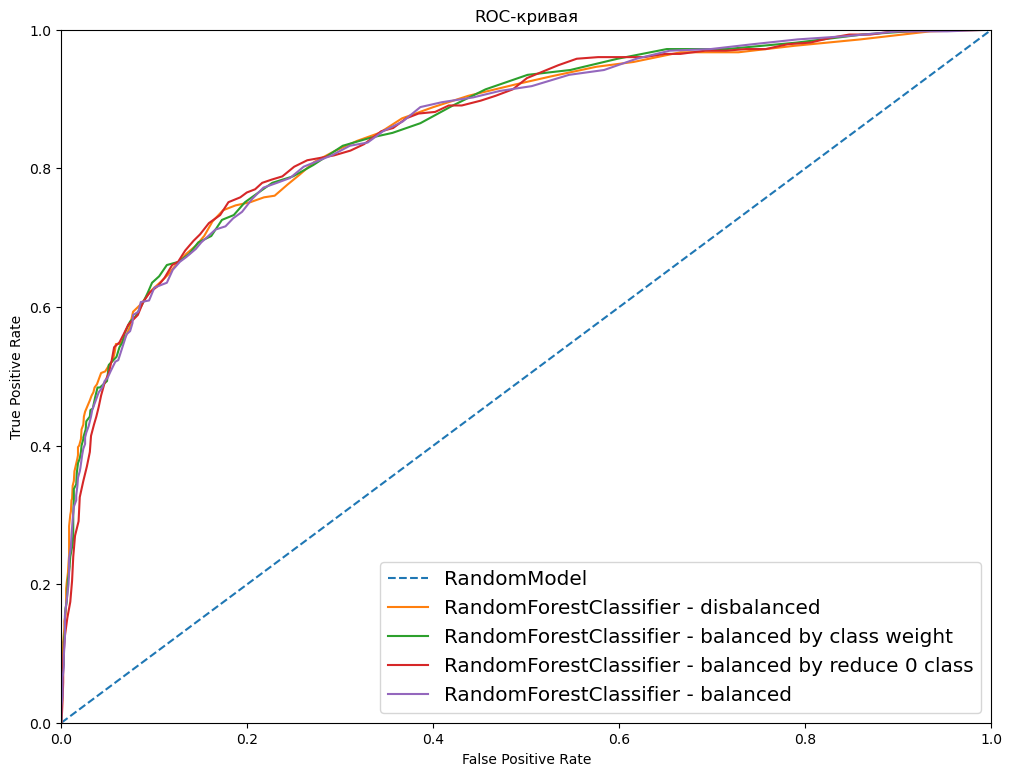

In [35]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


model = RandomForestClassifier(random_state=42, n_estimators=90)
model.fit(X_train, y_train)
pred_test = model.predict(X_test)
probabilities_test = model.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
auc_roc = roc_auc_score(y_test, probabilities_one_test)
print('AUC-ROC RandomForestClassifier - disbalanced',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier - disbalanced')

model = RandomForestClassifier(random_state=42, n_estimators=90, class_weight='balanced')
model.fit(X_train, y_train)
pred_test = model.predict(X_test)
probabilities_test = model.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
auc_roc = roc_auc_score(y_test, probabilities_one_test)
print('AUC-ROC RandomForestClassifier - balanced by class weight',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier - balanced by class weight')

model = RandomForestClassifier(random_state=42, n_estimators=90)
model.fit(X_downsampled, y_downsampled)
pred_test = model.predict(X_test)
probabilities_test = model.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
auc_roc = roc_auc_score(y_test, probabilities_one_test)
print('AUC-ROC RandomForestClassifier - balanced by reduce 0 class',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier - balanced by reduce 0 class')

model = RandomForestClassifier(random_state=42, n_estimators=90)
model.fit(features_upsampled, target_upsampled)
pred_test = model.predict(X_test)
probabilities_test = model.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
auc_roc = roc_auc_score(y_test, probabilities_one_test)
print('AUC-ROC RandomForestClassifier - balanced by grow 1 class',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier - balanced')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

### Вывод по разделу 4

ПО ТЗ F1-мера д.б. больше 0.59.
Хотя по метрикам модель <b>Случайного леса с уменьшенным количеством классов 0</b> показывает не лучшие результаты, но по бизнес задаче она подходит нам лучше всего.
+ Recall - 0.77 т.е. находит 77% процентов отточников
+ Precision 0.50 принимает за отточникоа каждого второго на самом деле неотточного клиента.

Модель старается собрать больше данных, чем показать верную точность (recall > precision). Процент попадания в классы достаточно высокий 0.787

### Итоговый вывод

При работе с проектом было выполнено:

1. Изучены данные. Разбиты данные на тренировочную, валидационную и тестовую выборку.
2. Исследована задача. Проверены модели на данных без изменений.
3. Скоректирован балланс класса. Изменен вес класса.
4. Получена улучшенная модель. Проведен поиск гиперпараметров.
5. Проведен финальный тест.

Модель <b>Случайного леса с уменьшенным количеством классов 0</b> показывает не лучшие результаты, но по бизнес задаче она подходит нам лучше всего.

- Recall - 0.77 т.е. находит 77% процентов отточников
- Precision 0.50 принимает за отточника каждого второго на самом деле неотточного клиента.
- Модель старается собрать больше данных, чем показать верную точность (recall > precision). 
- Процент попадания в классы достаточно высокий 0.787